In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os

In [7]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [8]:
train_transform

Compose(
    RandomRotation(degrees=(-10, 10), resample=False, expand=False)
    RandomHorizontalFlip(p=0.5)
    Resize(size=224, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [35]:
root = 'original/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)

test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

class_names = train_data.classes

In [36]:
train_data

Dataset ImageFolder
    Number of datapoints: 18743
    Root Location: original/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/CATS_DOGS\train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             RandomHorizontalFlip(p=0.5)
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [37]:
class_names

['CAT', 'DOG']

In [38]:
len(train_data)

18743

In [39]:
len(test_data)

6251

In [40]:
for images,labels in train_loader:
    break

In [41]:
images.shape

torch.Size([10, 3, 224, 224])

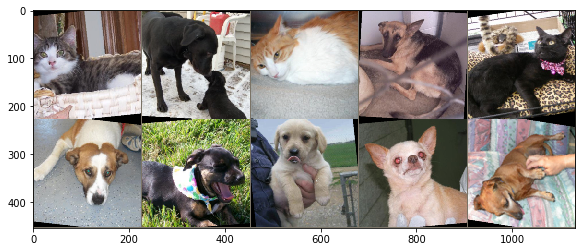

In [42]:
im = make_grid(images,nrow=5)

# Inverse normalization to view the image normally

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)));

In [43]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54*54*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [44]:
CNNmodel = ConvolutionalNetwork()
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(),lr=0.001)

In [46]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
________
 5610222


In [47]:
import time
start_time = time.time()

epochs = 4

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        
        b += 1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'Epoch: {i}  Loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            y_val = CNNmodel(X_test)
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum() 
            tst_corr = tst_corr + batch_corr
            
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



total_time = time.time() - start_time
print(f'Total time elapsed: {total_time/60} minutes')

Epoch: 0  Loss: 0.5806710124015808
Epoch: 0  Loss: 0.5099404454231262
Epoch: 0  Loss: 0.4768262803554535
Epoch: 0  Loss: 0.4743382930755615
Epoch: 0  Loss: 0.5690773129463196
Epoch: 0  Loss: 0.5452725291252136
Epoch: 0  Loss: 0.5729948282241821
Epoch: 0  Loss: 1.157286286354065
Epoch: 0  Loss: 0.5624266266822815
Epoch: 1  Loss: 0.48845070600509644
Epoch: 1  Loss: 0.24667461216449738
Epoch: 1  Loss: 0.4701741635799408
Epoch: 1  Loss: 0.5981239676475525
Epoch: 1  Loss: 0.46468204259872437
Epoch: 1  Loss: 0.6043957471847534
Epoch: 1  Loss: 0.4167712330818176
Epoch: 1  Loss: 0.2725525498390198
Epoch: 1  Loss: 0.4090674817562103
Epoch: 2  Loss: 0.38514867424964905
Epoch: 2  Loss: 0.4096848964691162
Epoch: 2  Loss: 0.42358341813087463
Epoch: 2  Loss: 0.4914914667606354
Epoch: 2  Loss: 0.18691511452198029
Epoch: 2  Loss: 0.5214720368385315
Epoch: 2  Loss: 0.4571189284324646
Epoch: 2  Loss: 0.6748678088188171
Epoch: 2  Loss: 0.21960246562957764
Epoch: 3  Loss: 0.49604034423828125
Epoch: 3  Los

In [48]:
torch.save(CNNmodel.state_dict(),'my4epochmodel.pt')

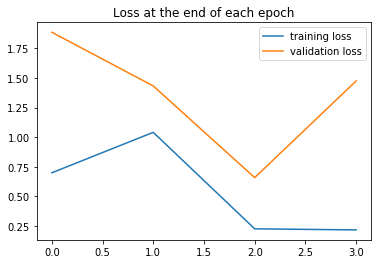

In [49]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

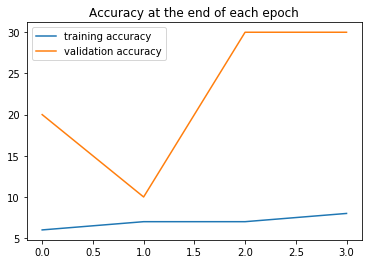

In [51]:
plt.plot([t/1874 for t in train_correct], label='training accuracy')
plt.plot([t/62 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [53]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/6251:.3f}%')

[tensor(1252), tensor(626), tensor(1878), tensor(1878)]
Test accuracy: 30.043%
